https://chatgpt.com/share/68703dc5-4ff0-8008-9153-42348685b941

In [1]:
import gspread
import pandas as pd
import re
from gspread_dataframe import get_as_dataframe
from collections import defaultdict
import time
import matplotlib.pyplot as plt

In [2]:
CREDENTIALS_JSON = '../rm4mt-463314-3ce1280ee29c.json'
sheet_urls = [
    "https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1LHsMMvKhTEgagmZKQl7ax1H4BJyDBImYMbeE8sNPjJw/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1PRIfwNA4l2TG3oMFlgM8LIGuxvCH8prfgEvbGMDhqIY/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/11WAU3v3uKN1wV3G7crmGDyo3u4QX4aGlhWpQN7tn9As/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1pSBxhdqGvu2I5z_8C6l6pePV-IkIl31MM83Py_ILRqU/edit?usp=sharing",
]

In [3]:
gc = gspread.service_account(filename=CREDENTIALS_JSON)
all_data = {}

In [ ]:
for sheet_url in sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how='all').dropna(axis=1, how='all')
        ws_data[worksheet.title] = df
        time.sleep(2)
    all_data[sheet_url] = ws_data

Reading Sheet: https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing


In [13]:
def split_by_metric(all_data):
    dfs_by_metric = defaultdict(list)  # metric: list of rows

    for sheet_url, ws_dict in all_data.items():
        for ws_name, df in ws_dict.items():
            match = re.match(
                r"(.+?)_((comet_score|comet_kiwi_score|grb|grf|gea_100|gea_5|thinking_length))$",
                ws_name,
            )
            if not match:
                continue
            task = match.group(1)
            metric = match.group(2)
            # Check must have model & lang_pair
            if not {"model", "lang_pair"}.issubset(df.columns):
                continue
            # Budget Column - include numeric columns and "low", "high"
            numeric_cols = [
                col
                for col in df.columns
                if isinstance(col, (int, float))
                or (isinstance(col, str) and col.isdigit())
            ]
            text_budget_cols = [col for col in df.columns if col in ["low", "high"]]
            budget_cols = sorted(numeric_cols, key=lambda x: int(x)) + text_budget_cols

            for _, row in df.iterrows():
                model = row["model"]
                lang_pair = row["lang_pair"]
                for budget in budget_cols:
                    val = row[budget]
                    if pd.isna(val):
                        continue
                    # Handle budget value - keep as string for "low"/"high", convert to int for numeric
                    budget_val = budget if budget in ["low", "high"] else int(budget)
                    dfs_by_metric[metric].append(
                        {
                            "model": model,
                            "task": task,
                            "metric": metric,
                            "lang_pair": lang_pair,
                            "budget": budget_val,
                            "score": float(val),
                        }
                    )

    # To DataFrame
    for metric in dfs_by_metric:
        dfs_by_metric[metric] = pd.DataFrame(dfs_by_metric[metric])

    return dfs_by_metric


dfs_by_metric = split_by_metric(all_data)

In [14]:
print("Available Metrics:")
print(list(dfs_by_metric.keys()))

Available Metrics:
['comet_score', 'comet_kiwi_score', 'grb', 'grf', 'gea_100', 'gea_5', 'thinking_length']


In [15]:
dfs_by_metric['comet_kiwi_score']

,model,task,metric,lang_pair,budget,score
0,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_kiwi_score,Avg,0,0.694328
1,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_kiwi_score,Avg,100,0.694022
2,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_kiwi_score,Avg,200,0.694338
3,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_kiwi_score,Avg,300,0.693046
4,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_kiwi_score,Avg,400,0.692750
...,...,...,...,...,...,...
3312,grok-3-mini,CAMT,comet_kiwi_score,en-zh,low,0.773715
3313,grok-3-mini,RAGtrans,comet_kiwi_score,Avg,high,0.789520
3314,grok-3-mini,RAGtrans,comet_kiwi_score,Avg,low,0.793470
3315,grok-3-mini,RAGtrans,comet_kiwi_score,en-zh,high,0.789520


In [16]:
def plot_model_scores(
    df, 
    task, 
    lang_pair, 
    models,
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(7,5)
):
    plot_df = df[
        (df['task'] == task) &
        (df['lang_pair'] == lang_pair) &
        (df['model'].isin(models))
    ]
    if plot_df.empty:
        print('No data found for the given criteria. Please check')
        return
    
    plt.figure(figsize=figsize)
    for model in models:
        sub = plot_df[plot_df['model'] == model]
        sub = sub.sort_values('budget')
        plt.plot(sub['budget'], sub['score'], marker='o', label=model)
    plt.xlabel('Budget')
    plt.ylabel('Score')
    plt.title(f'{task} | {lang_pair}')
    plt.xticks(budget_ticks)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [17]:
# plot_model_scores(
#     dfs_by_metric['comet_kiwi_score'],
#     task='WMT23-Biomedical-Sentence',
#     lang_pair='Avg',
#     # models=['Qwen3-0.6B', 'Qwen3-1.7B']
#     # models=['Qwen3-4B', 'Qwen3-8B']
#     # models=['Qwen3-14B', 'Qwen3-32B']
# )

In [18]:
def sort_budget_key(b):
    if isinstance(b, (int, float)):
        return (0, b)
    elif isinstance(b, str):
        if b.isdigit():
            return (0, int(b))
        elif b == "low":
            return (1, 0)
        elif b == "high":
            return (2, 0)
    return (3, str(b))


def plot_models_groups_side_by_side(
    df,
    task,
    metric,
    lang_pair,
    model_groups,
    budget_ticks=None,
    figsize=(16, 5),
):
    n_groups = len(model_groups)
    fig, axes = plt.subplots(1, n_groups, figsize=figsize, sharey=True)
    if n_groups == 1:
        axes = [axes]

    for idx, models in enumerate(model_groups):
        ax = axes[idx]
        group_df = df[
            (df["task"] == task)
            & (df["metric"] == metric)
            & (df["lang_pair"] == lang_pair)
            & (df["model"].isin(models))
        ]
        if group_df.empty:
            ax.set_title("No data available for this group")
            continue

        all_budgets = set()
        for model in models:
            sub = group_df[group_df["model"] == model].copy()
            if sub.empty:
                continue
            sub = sub.sort_values(by="budget", key=lambda x: x.map(sort_budget_key))
            all_budgets.update(sub["budget"])
            ax.plot(sub["budget"].astype(str), sub["score"], marker="o", label=model)

        sorted_budgets = sorted(all_budgets, key=sort_budget_key)

        is_numeric_group = all(
            isinstance(b, (int, float)) or (isinstance(b, str) and b.isdigit())
            for b in sorted_budgets
        )
        if is_numeric_group:
            xticks = [
                str(b)
                for b in (budget_ticks if budget_ticks is not None else sorted_budgets)
            ]
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks, rotation=45)
        else:
            # grok-3-mini
            xticks = [str(b) for b in sorted_budgets]
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks, rotation=45)

        ax.set_xlabel("Budget")
        ax.grid(True)
        if idx == 0:
            ax.set_ylabel("Score")
        # ax.set_title(f"Group {idx+1}")
        ax.legend(loc="lower right", framealpha=0.25)

    plt.suptitle(f"{task} | {metric} | {lang_pair}")
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

### Biomedical Translation

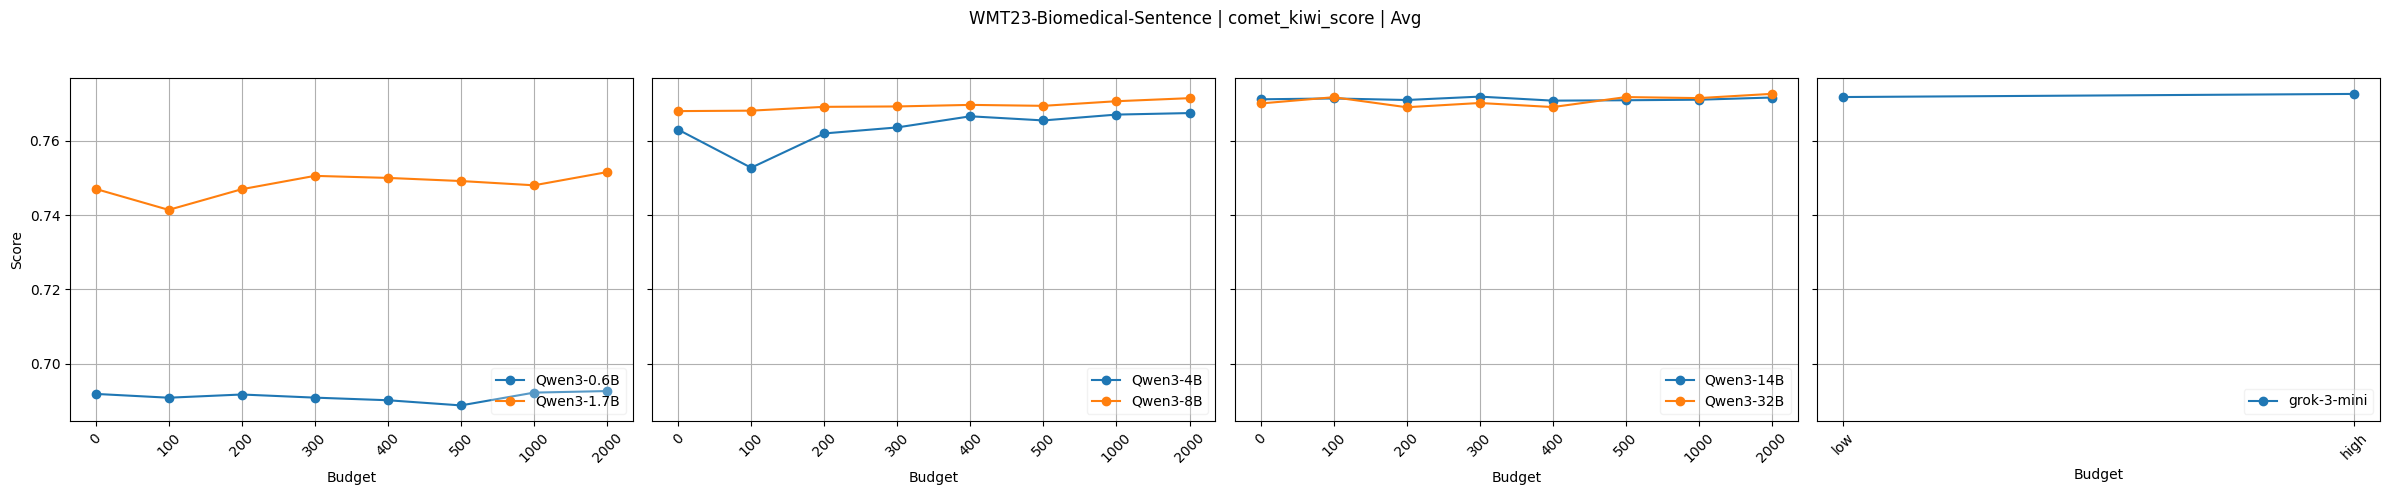

In [19]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='WMT23-Biomedical-Sentence',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
        ['grok-3-mini'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5)
)

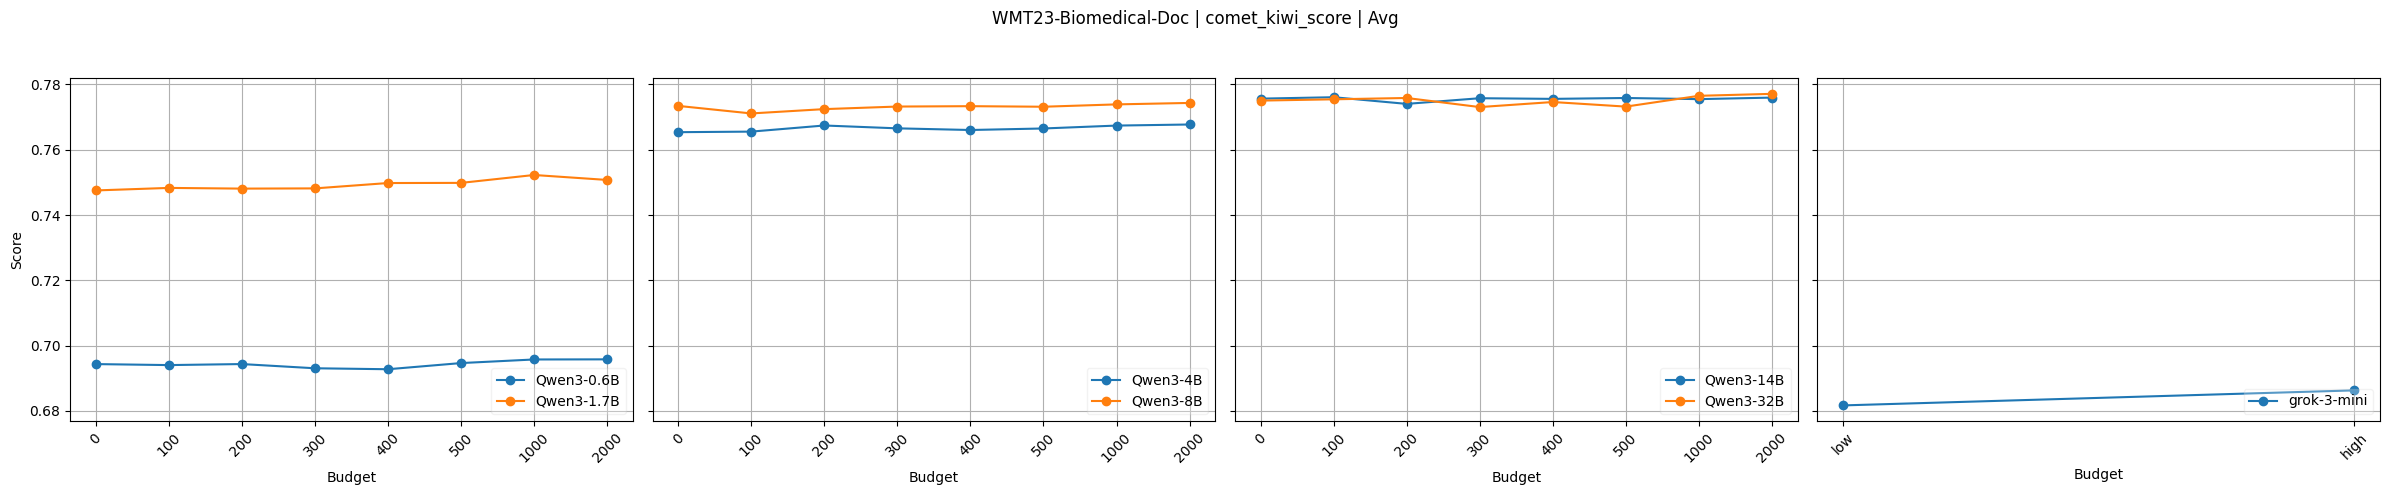

In [20]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='WMT23-Biomedical-Doc',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
        ['grok-3-mini'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5)
)

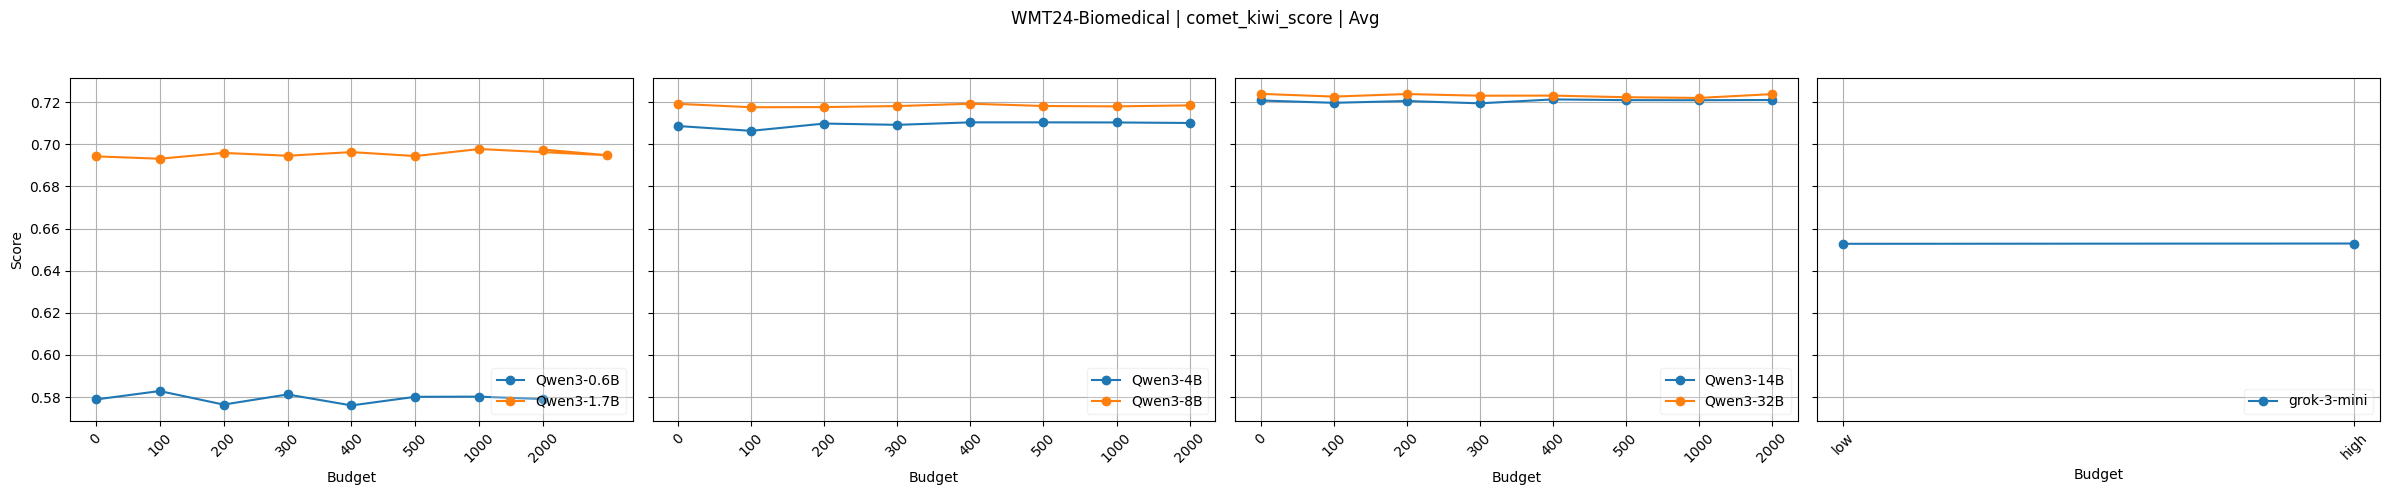

In [21]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='WMT24-Biomedical',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
        ['grok-3-mini'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5)
)

### Terminminology Translation

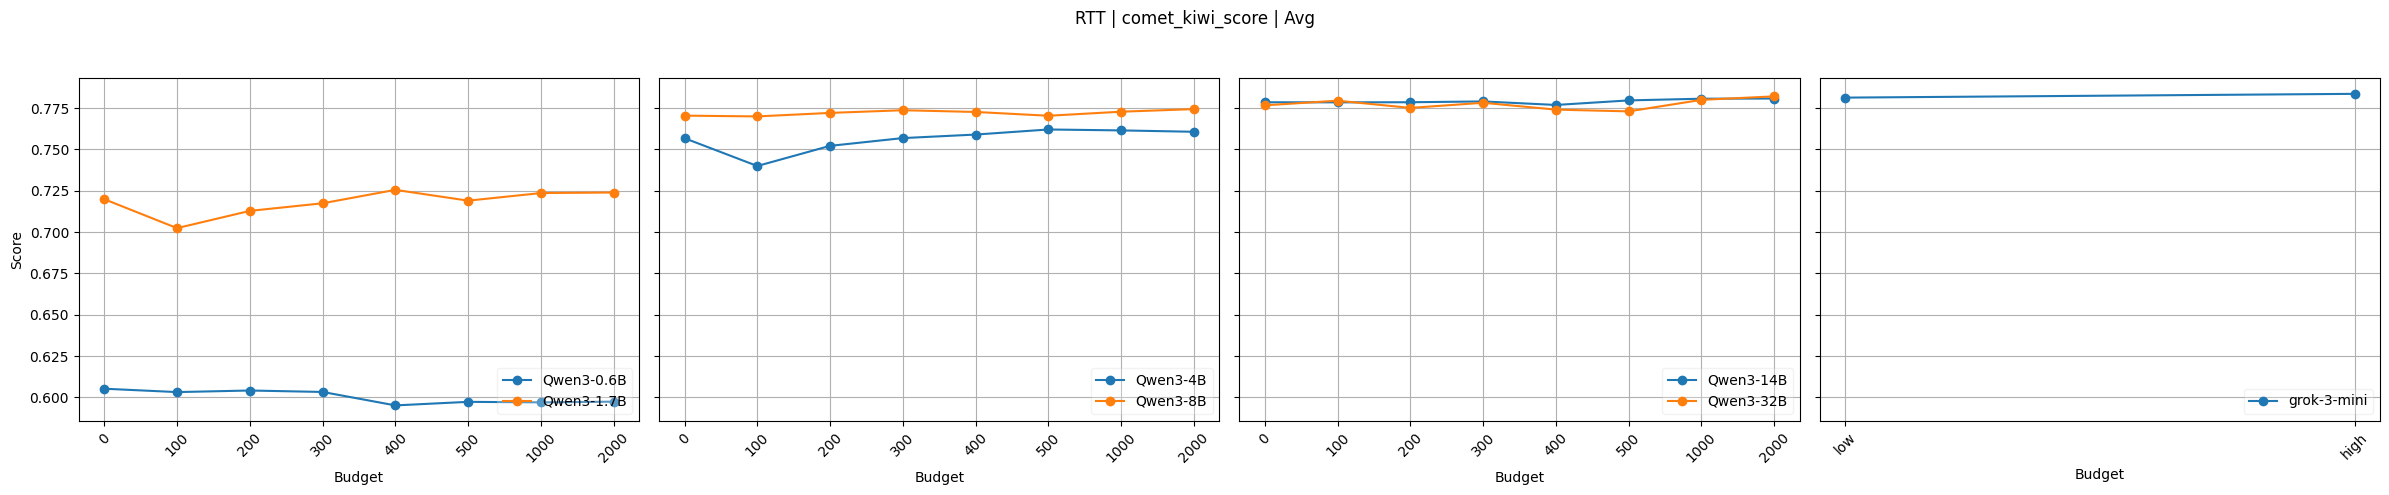

In [22]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='RTT',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
        ['grok-3-mini'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5)
)

### Commosence Translation

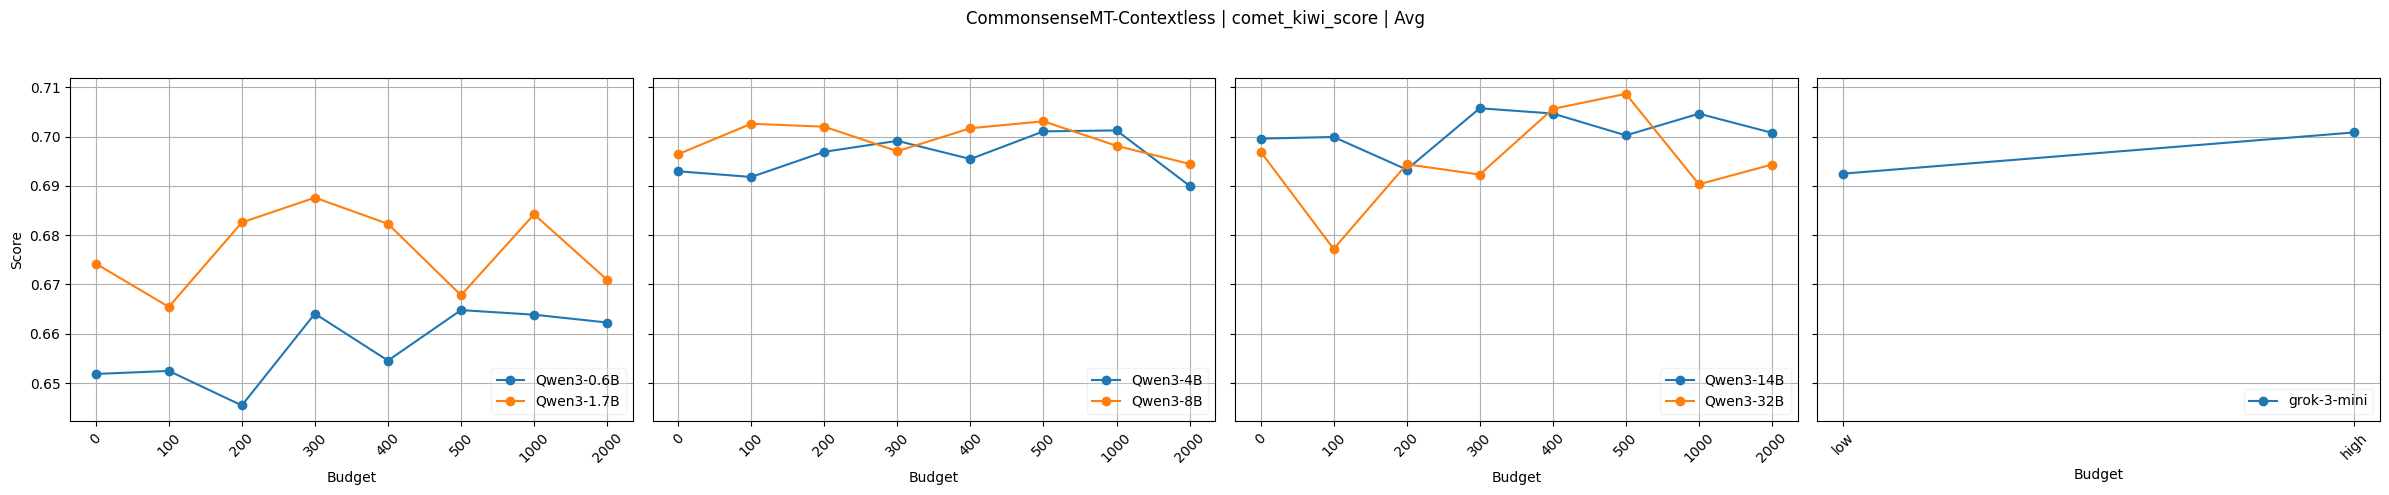

In [23]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='CommonsenseMT-Contextless',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
        ['grok-3-mini'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5)
)

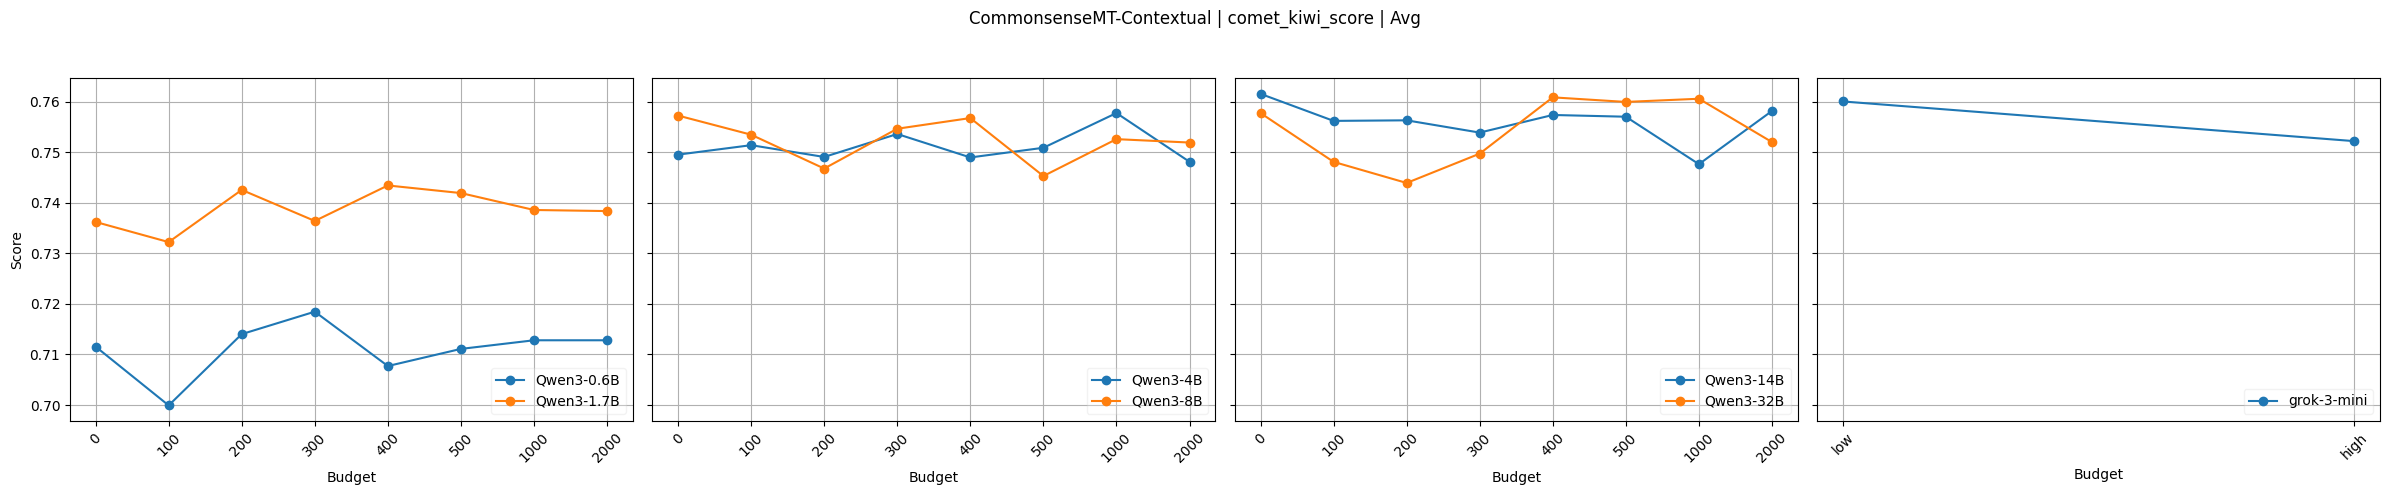

In [24]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='CommonsenseMT-Contextual',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
        ['grok-3-mini'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5)
)

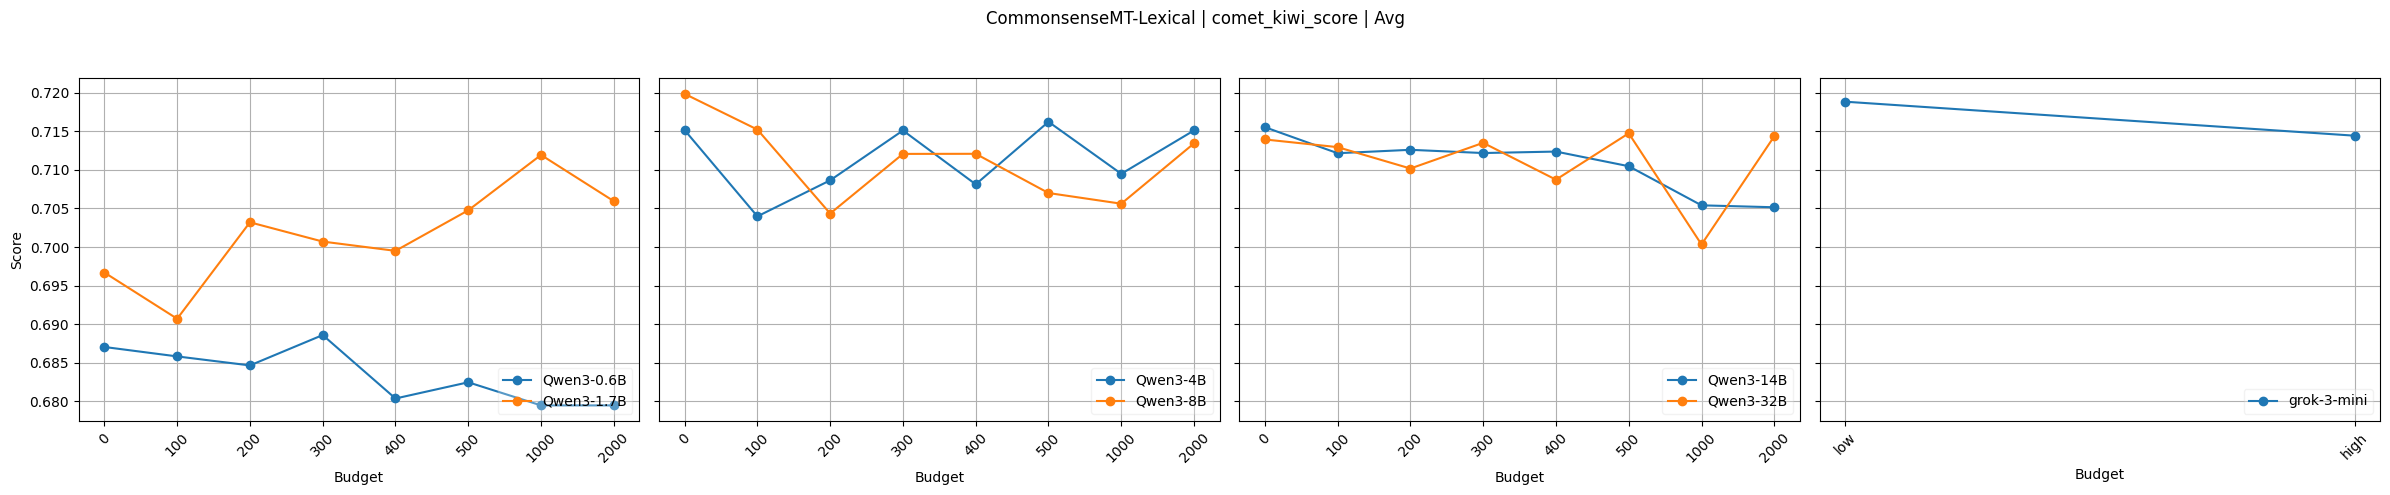

In [25]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='CommonsenseMT-Lexical',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
        ['grok-3-mini'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5)
)

### Culture Translation

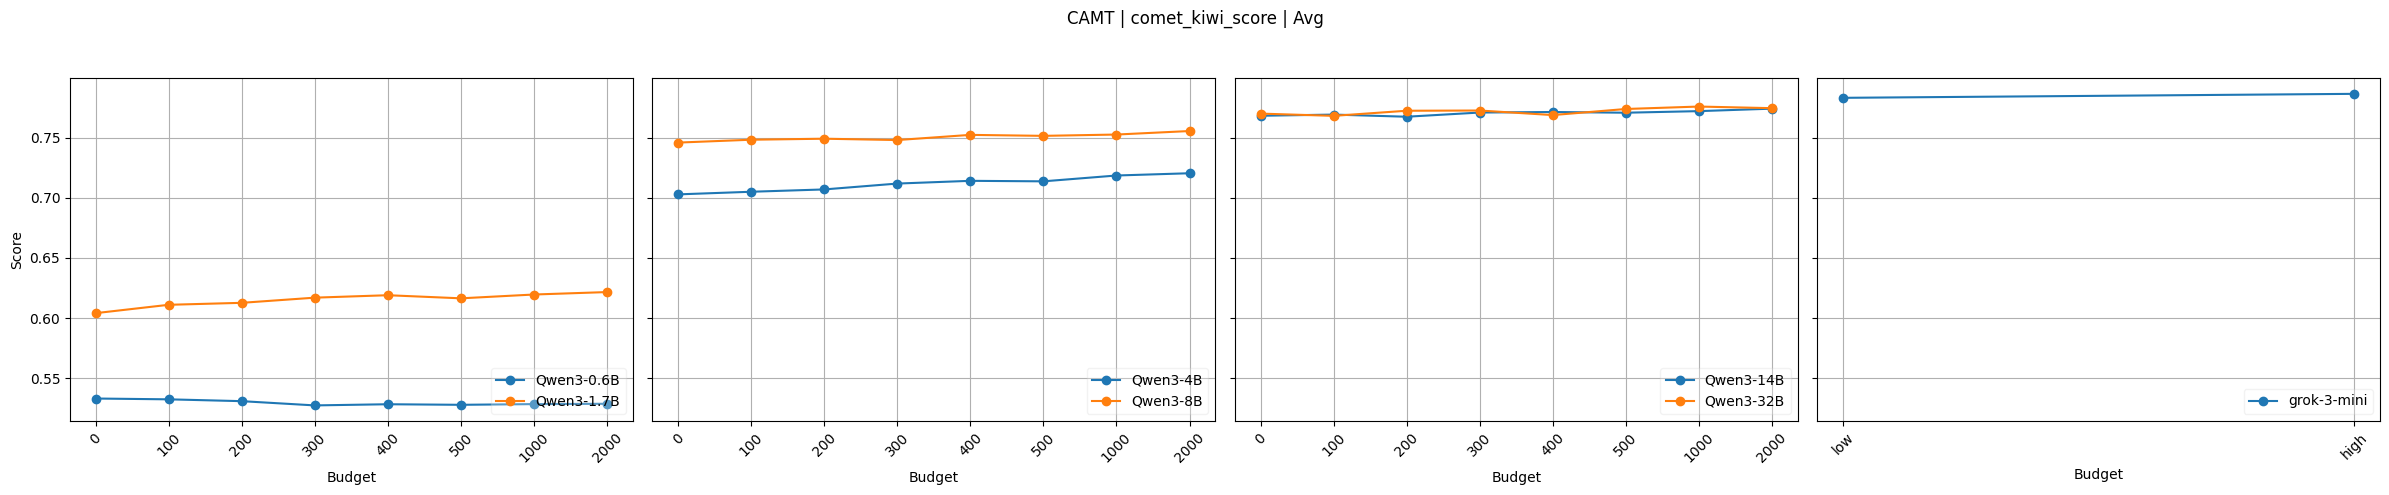

In [26]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='CAMT',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
        ['grok-3-mini'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5)
)

### Literterature Transaltion

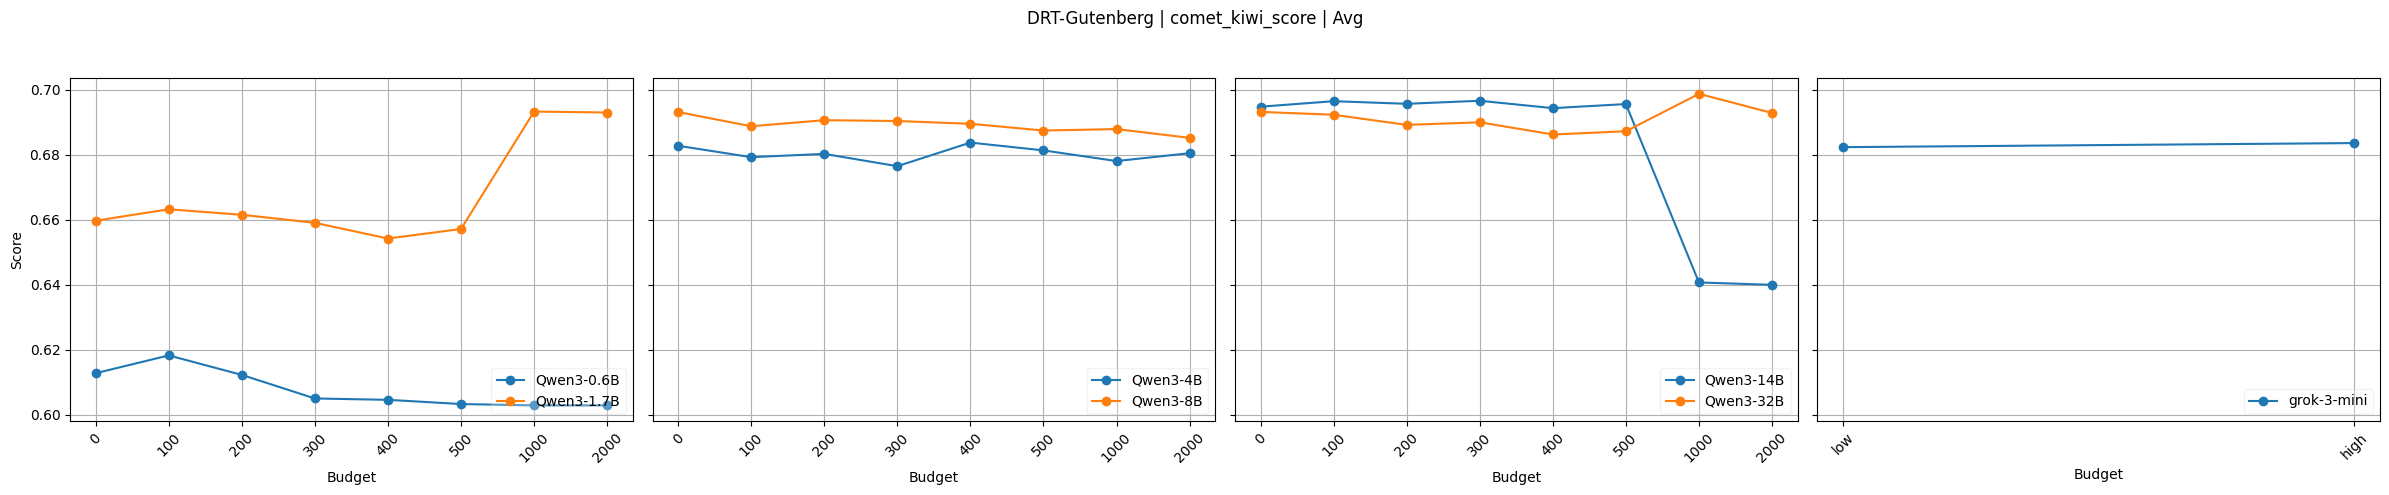

In [27]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='DRT-Gutenberg',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
        ['grok-3-mini'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5)
)

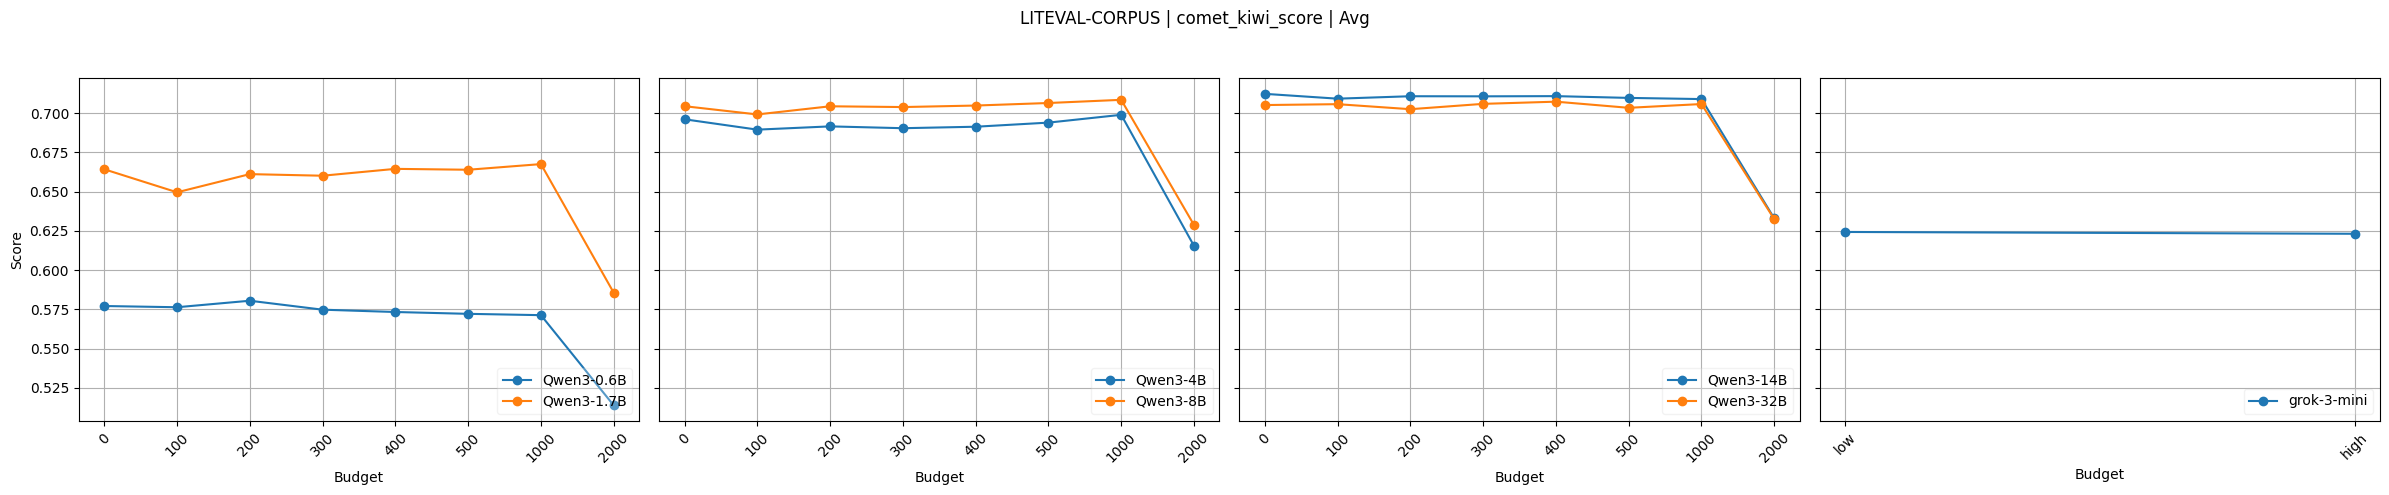

In [28]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='LITEVAL-CORPUS',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
        ['grok-3-mini'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5)
)

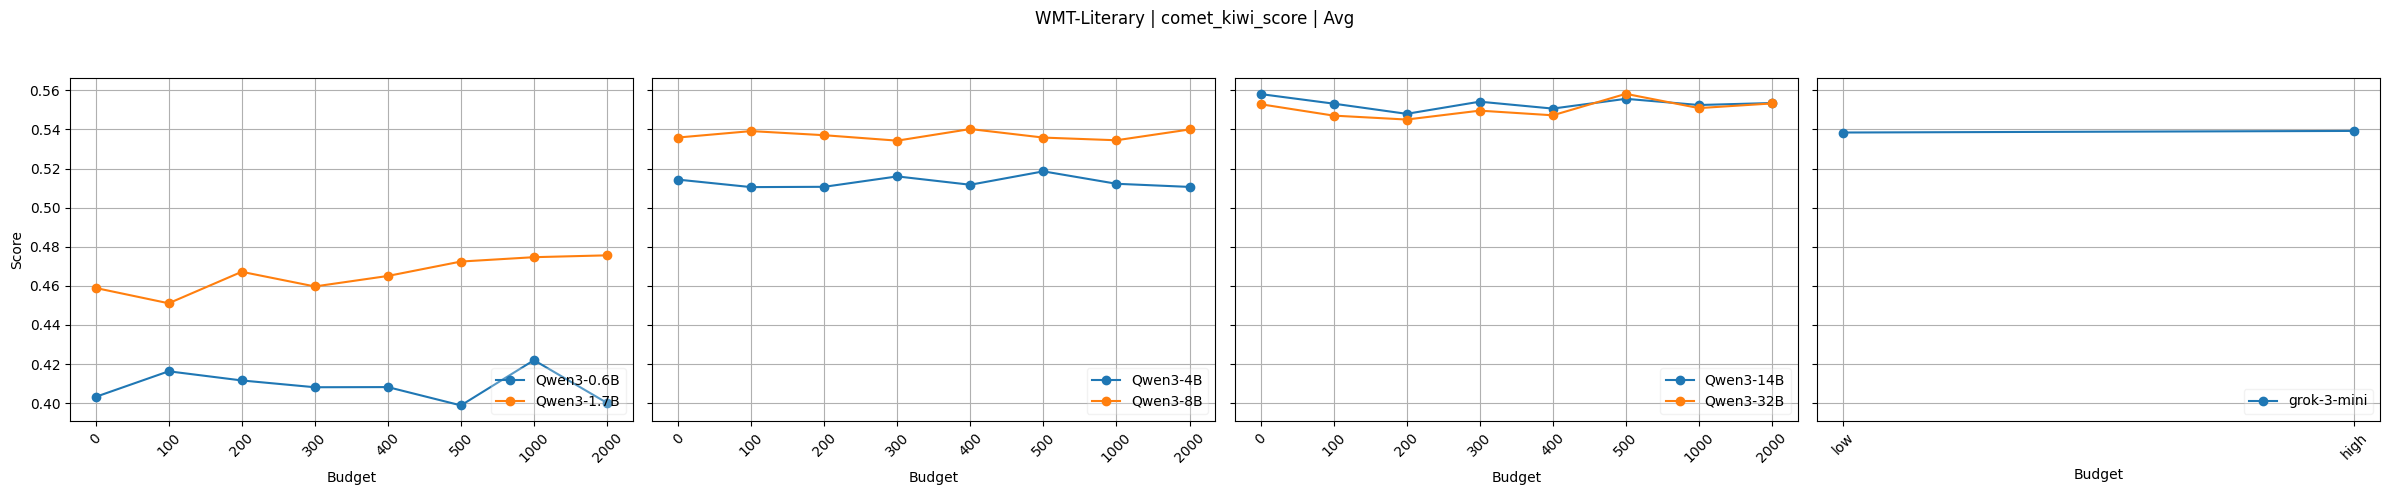

In [30]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='WMT-Literary',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
        ['grok-3-mini'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5)
)

### RAG Transaltion

In [ ]:
plot_models_groups_side_by_side(
    dfs_by_metric["comet_kiwi_score"],
    task="RAGtrans",
    metric="comet_kiwi_score",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)